In [ ]:
#!pip install torch torchvision torchaudio matplotlib scikit-learn

import os
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

print('PyTorch:', torch.__version__)

PyTorch: 2.8.0+cu126


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

### **set cuda to use gpu and fixed seed**

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


### **load dataset**
* load from train.p, valid.p, test.p

In [ ]:
def load_pickled_dataset(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
    X = data['features']
    y = data['labels']
    return X, y

train_X, train_y = load_pickled_dataset("/content/drive/MyDrive/DL_Project_4032/content/train.p")
valid_X, valid_y = load_pickled_dataset("/content/drive/MyDrive/DL_Project_4032/content/valid.p")
test_X,  test_y  = load_pickled_dataset("/content/drive/MyDrive/DL_Project_4032/content/test.p")

print("Train:", train_X.shape, train_y.shape)
print("Valid:", valid_X.shape, valid_y.shape)
print("Test :", test_X.shape,  test_y.shape, end='\n')
print(train_X[10].shape, '---', train_y[10])

Train: (34799, 32, 32, 3) (34799,)
Valid: (4410, 32, 32, 3) (4410,)
Test : (12630, 32, 32, 3) (12630,)
(32, 32, 3) --- 41


### **preprocessing and augmentation of data**

In [ ]:
normalize = transforms.Normalize(mean=[0.3403, 0.3121, 0.3214],
                                 std=[0.2724, 0.2608, 0.2669])

base_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

aug_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    normalize
])

def make_tensor_dataset(X, y, transform):
    tensors = []
    for i in range(len(X)):
        img = Image.fromarray(X[i])  # convert numpy -> PIL
        img_t = transform(img)
        tensors.append(img_t.unsqueeze(0))
    images_tensor = torch.cat(tensors, dim=0)
    labels_tensor = torch.tensor(y, dtype=torch.long)
    return TensorDataset(images_tensor, labels_tensor)

use_augmentation = False
train_ds = make_tensor_dataset(train_X, train_y, aug_transform if use_augmentation else base_transform)
valid_ds = make_tensor_dataset(valid_X, valid_y, base_transform)
test_ds  = make_tensor_dataset(test_X,  test_y,  base_transform)

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Batches:", len(train_loader), len(val_loader), len(test_loader))

Batches: 272 35 99


### **make models - create architecture**

In [ ]:
# basic block
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# tinyResNet model
class TinyResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=43, base_channels=16):
        super(TinyResNet, self).__init__()
        self.in_planes = base_channels
        self.conv1 = nn.Conv2d(3, base_channels, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, base_channels, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, base_channels*2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, base_channels*4, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(base_channels*4*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, stride=s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# simpleCNN model
# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes=43):
#         super(SimpleCNN, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
#             nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
#             nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1))
#         )
#         self.classifier = nn.Linear(128, num_classes)

#     def forward(self, x):
#         x = self.features(x)
#         x = torch.flatten(x,1)
#         x = self.classifier(x)
#         return x
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)# flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)# logits
        return x

def get_pretrained_backbone(name='mobilenet_v2', num_classes=43, pretrained=True):
    name = name.lower()
    if name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=pretrained)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
    elif name == 'densenet121':
        model = models.densenet121(pretrained=pretrained)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    elif name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=pretrained)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
    elif name == 'resnet34':
        model = models.resnet34(pretrained=pretrained)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    else:
        raise ValueError('Unknown backbone: ' + name)
    return model

### **training models**

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs.detach(), dim=1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc, all_labels, all_preds

def plot_metrics(history, title_prefix=''):
    epochs = list(range(1, len(history['train_loss'])+1))
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='train_loss')
    plt.plot(epochs, history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'{title_prefix} Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='train_acc')
    plt.plot(epochs, history['val_acc'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'{title_prefix} Accuracy'); plt.legend()
    plt.show()

def train_model(model, train_loader, val_loader, device, num_epochs=20, lr=1e-3, weight_decay=1e-4, save_path=None):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0.0
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    for epoch in range(1, num_epochs+1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = eval_model(model, val_loader, criterion, device)
        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)
        print(f'Epoch {epoch}/{num_epochs}: train_loss={train_loss:.4f} acc={train_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f}')
        if val_acc > best_val_acc and save_path is not None:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print('Saved best model to', save_path)
    return model, history


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most u

\n--- Training tinyresnet ---


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20: train_loss=1.7045 acc=0.5354 | val_loss=0.8029 acc=0.7825
Saved best model to /content/tinyresnet_best.pth
Epoch 2/20: train_loss=0.2313 acc=0.9536 | val_loss=0.3442 acc=0.9084
Saved best model to /content/tinyresnet_best.pth
Epoch 3/20: train_loss=0.0641 acc=0.9896 | val_loss=0.1995 acc=0.9544
Saved best model to /content/tinyresnet_best.pth
Epoch 4/20: train_loss=0.0271 acc=0.9957 | val_loss=0.1613 acc=0.9585
Saved best model to /content/tinyresnet_best.pth
Epoch 5/20: train_loss=0.0272 acc=0.9949 | val_loss=0.2250 acc=0.9542
Epoch 6/20: train_loss=0.0237 acc=0.9953 | val_loss=0.2101 acc=0.9499
Epoch 7/20: train_loss=0.0108 acc=0.9985 | val_loss=0.1964 acc=0.9592
Saved best model to /content/tinyresnet_best.pth
Epoch 8/20: train_loss=0.0058 acc=0.9991 | val_loss=0.4517 acc=0.8794
Epoch 9/20: train_loss=0.0129 acc=0.9976 | val_loss=0.1295 acc=0.9751
Saved best model to /content/tinyresnet_best.pth
Epoch 10/20: train_loss=0.0141 acc=0.9973 | val_loss=0.2829 acc=0.9204
Epoch

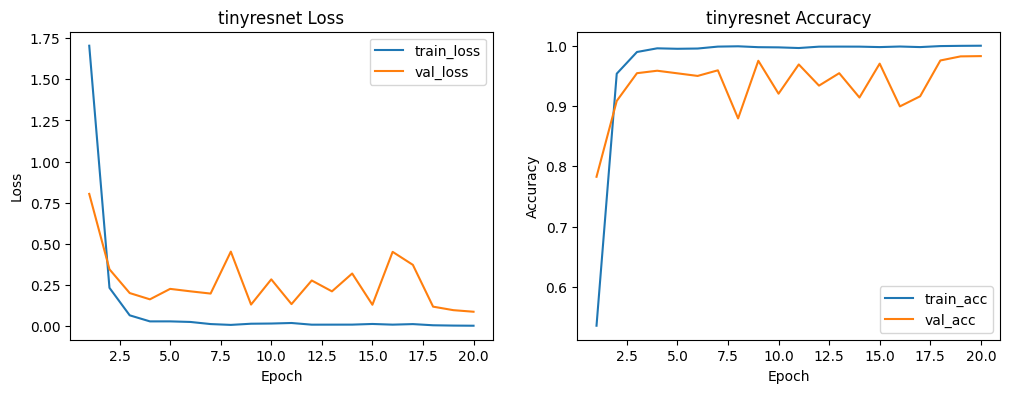

\n--- Training simplecnn ---
Epoch 1/20: train_loss=1.8349 acc=0.4654 | val_loss=0.8743 acc=0.7497
Saved best model to /content/simplecnn_best.pth
Epoch 2/20: train_loss=0.3208 acc=0.9009 | val_loss=0.4301 acc=0.8853
Saved best model to /content/simplecnn_best.pth
Epoch 3/20: train_loss=0.1236 acc=0.9621 | val_loss=0.3532 acc=0.9027
Saved best model to /content/simplecnn_best.pth
Epoch 4/20: train_loss=0.0753 acc=0.9777 | val_loss=0.3478 acc=0.9098
Saved best model to /content/simplecnn_best.pth
Epoch 5/20: train_loss=0.0553 acc=0.9839 | val_loss=0.3068 acc=0.9082
Epoch 6/20: train_loss=0.0395 acc=0.9887 | val_loss=0.2577 acc=0.9197
Saved best model to /content/simplecnn_best.pth
Epoch 7/20: train_loss=0.0325 acc=0.9911 | val_loss=0.3065 acc=0.9265
Saved best model to /content/simplecnn_best.pth
Epoch 8/20: train_loss=0.0298 acc=0.9914 | val_loss=0.2761 acc=0.9295
Saved best model to /content/simplecnn_best.pth
Epoch 9/20: train_loss=0.0248 acc=0.9929 | val_loss=0.3976 acc=0.9261
Epoch

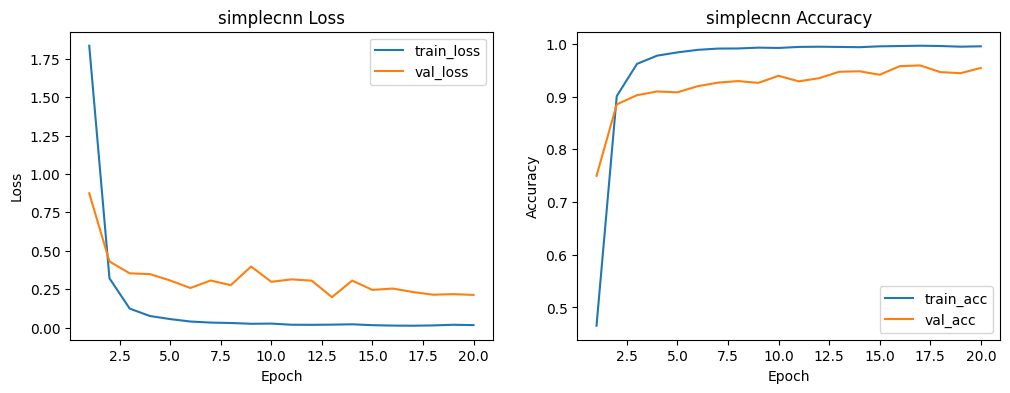

\n--- Training mobilenet_v2 ---
Epoch 1/20: train_loss=0.5598 acc=0.8282 | val_loss=0.3227 acc=0.8986
Saved best model to /content/mobilenet_v2_best.pth
Epoch 2/20: train_loss=0.0892 acc=0.9722 | val_loss=0.2447 acc=0.9345
Saved best model to /content/mobilenet_v2_best.pth
Epoch 3/20: train_loss=0.0458 acc=0.9866 | val_loss=0.3119 acc=0.9200
Epoch 4/20: train_loss=0.0497 acc=0.9854 | val_loss=0.2294 acc=0.9327
Epoch 5/20: train_loss=0.0369 acc=0.9892 | val_loss=0.1429 acc=0.9610
Saved best model to /content/mobilenet_v2_best.pth
Epoch 6/20: train_loss=0.0240 acc=0.9932 | val_loss=0.1417 acc=0.9624
Saved best model to /content/mobilenet_v2_best.pth
Epoch 7/20: train_loss=0.0294 acc=0.9917 | val_loss=0.1907 acc=0.9508
Epoch 8/20: train_loss=0.0265 acc=0.9920 | val_loss=0.1659 acc=0.9603
Epoch 9/20: train_loss=0.0309 acc=0.9917 | val_loss=0.2201 acc=0.9467
Epoch 10/20: train_loss=0.0193 acc=0.9944 | val_loss=0.1372 acc=0.9628
Saved best model to /content/mobilenet_v2_best.pth
Epoch 11/20:

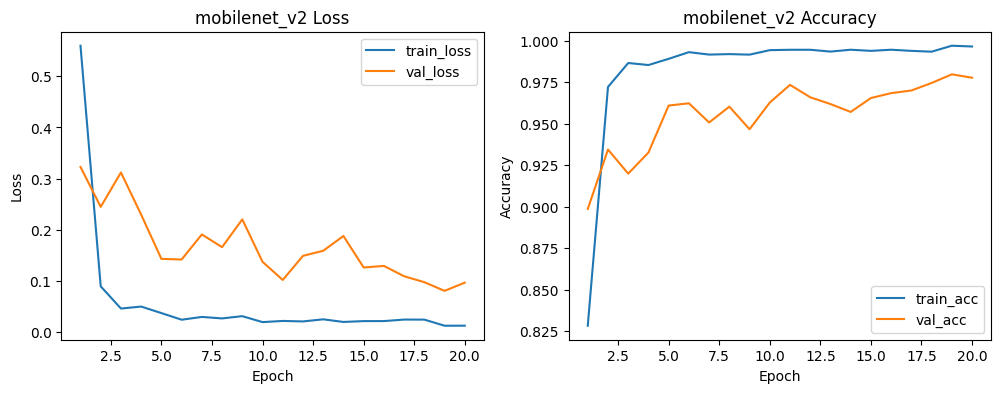

\n--- Training densenet121 ---
Epoch 1/20: train_loss=0.4076 acc=0.8822 | val_loss=0.4084 acc=0.8930
Saved best model to /content/densenet121_best.pth
Epoch 2/20: train_loss=0.0696 acc=0.9801 | val_loss=0.2197 acc=0.9449
Saved best model to /content/densenet121_best.pth
Epoch 3/20: train_loss=0.0371 acc=0.9896 | val_loss=0.2293 acc=0.9440
Epoch 4/20: train_loss=0.0328 acc=0.9910 | val_loss=0.2158 acc=0.9488
Saved best model to /content/densenet121_best.pth
Epoch 5/20: train_loss=0.0283 acc=0.9918 | val_loss=0.1803 acc=0.9596
Saved best model to /content/densenet121_best.pth
Epoch 6/20: train_loss=0.0374 acc=0.9899 | val_loss=0.2408 acc=0.9376
Epoch 7/20: train_loss=0.0222 acc=0.9942 | val_loss=0.1764 acc=0.9578
Epoch 8/20: train_loss=0.0203 acc=0.9948 | val_loss=0.2114 acc=0.9537
Epoch 9/20: train_loss=0.0196 acc=0.9945 | val_loss=0.1257 acc=0.9651
Saved best model to /content/densenet121_best.pth
Epoch 10/20: train_loss=0.0155 acc=0.9961 | val_loss=0.2030 acc=0.9601
Epoch 11/20: train

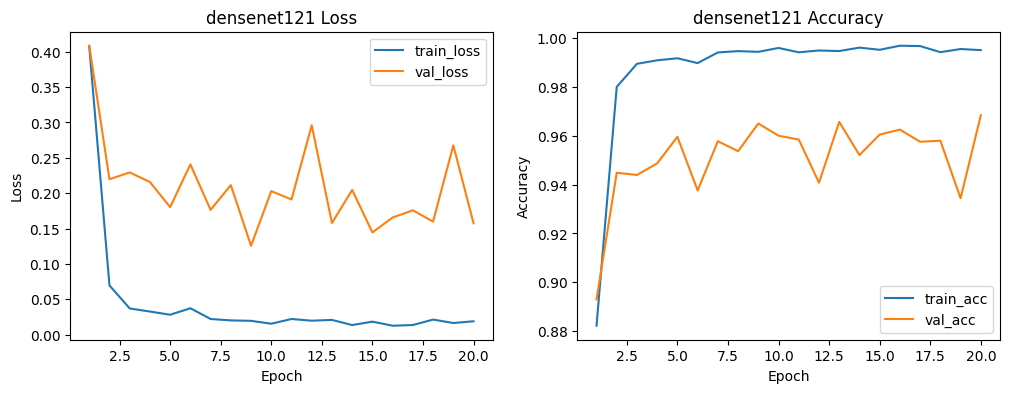

\n--- Training efficientnet_b0 ---
Epoch 1/20: train_loss=0.8724 acc=0.7441 | val_loss=0.6123 acc=0.8227
Saved best model to /content/efficientnet_b0_best.pth
Epoch 2/20: train_loss=0.1155 acc=0.9637 | val_loss=0.4151 acc=0.9027
Saved best model to /content/efficientnet_b0_best.pth
Epoch 3/20: train_loss=0.0659 acc=0.9799 | val_loss=0.3536 acc=0.9084
Saved best model to /content/efficientnet_b0_best.pth
Epoch 4/20: train_loss=0.0418 acc=0.9869 | val_loss=0.2865 acc=0.9213
Saved best model to /content/efficientnet_b0_best.pth
Epoch 5/20: train_loss=0.0361 acc=0.9891 | val_loss=0.2487 acc=0.9424
Saved best model to /content/efficientnet_b0_best.pth
Epoch 6/20: train_loss=0.0345 acc=0.9898 | val_loss=0.1878 acc=0.9522
Saved best model to /content/efficientnet_b0_best.pth
Epoch 7/20: train_loss=0.0295 acc=0.9923 | val_loss=0.2646 acc=0.9406
Epoch 8/20: train_loss=0.0235 acc=0.9930 | val_loss=0.2156 acc=0.9474
Epoch 9/20: train_loss=0.0235 acc=0.9932 | val_loss=0.2018 acc=0.9524
Saved best 

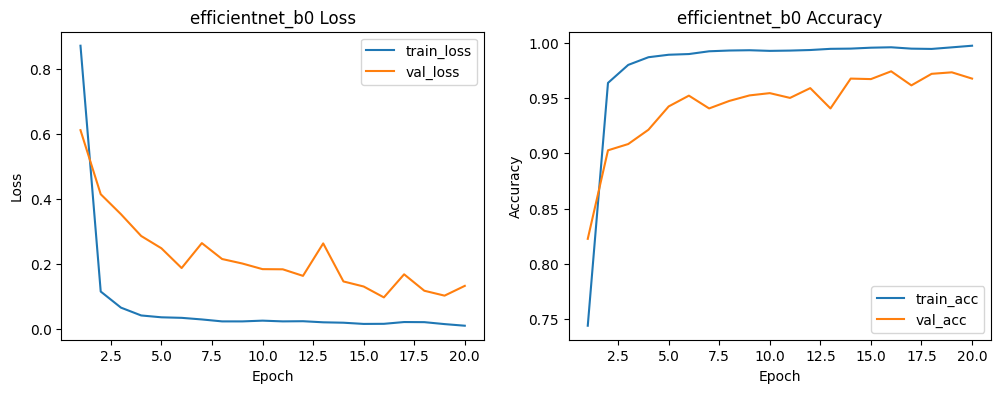

In [ ]:
n_epocs = 20
lr = 1e-3

models_to_train = {
    'tinyresnet': TinyResNet(BasicBlock, [2,2,2], num_classes=43, base_channels=16),
    'simplecnn': SimpleCNN(num_classes=43),
    'mobilenet_v2': get_pretrained_backbone('mobilenet_v2', num_classes=43, pretrained=True),
    'densenet121': get_pretrained_backbone('densenet121', num_classes=43, pretrained=True),
    'efficientnet_b0': get_pretrained_backbone('efficientnet_b0', num_classes=43, pretrained=True)
}

trained_models = {}
histories = {}
for name, model in models_to_train.items():
    print(f"\\n--- Training {name} ---")
    save_path = f'/content/{name}_best.pth'
    model, history = train_model(model, train_loader, val_loader, device,
                                 num_epochs=n_epocs, lr=lr, save_path=save_path)
    trained_models[name] = model
    histories[name] = history
    plot_metrics(history, title_prefix=name)

### **ensemble evaluation**

In [ ]:
def predict_proba(model, loader, device):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            all_probs.append(probs.cpu())
    return torch.cat(all_probs, dim=0)

# prediction for each model
probs_dict = {}
for name, model in trained_models.items():
    print(f"Predicting probabilities for {name} ...")
    probs_dict[name] = predict_proba(model, test_loader, device)

# avg softmax
avg_probs = torch.stack(list(probs_dict.values())).mean(dim=0)
ensemble_preds = avg_probs.argmax(dim=1).numpy()

y_true = torch.cat([y for _, y in test_loader], dim=0).numpy()

ensemble_acc = accuracy_score(y_true, ensemble_preds)
print(f"\nEnsemble Soft Voting Accuracy on Test set: {ensemble_acc:.4f}")


Predicting probabilities for tinyresnet ...
Predicting probabilities for simplecnn ...
Predicting probabilities for mobilenet_v2 ...
Predicting probabilities for densenet121 ...
Predicting probabilities for efficientnet_b0 ...

Ensemble Soft Voting Accuracy on Test set: 0.9853
